In [1]:
import sys
sys.path.append('../.') 

from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder
from src.embedders.osm_data_embedder import OSMDataEmbedder

import pandas as pd
import geopandas as gpd

from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
area = geocode_to_region_gdf("Wrocław, Poland")
regionalizer = H3Regionalizer(resolution=8)
embedder = CountEmbedder()
query = {"highway": True}

embeddings = OSMDataEmbedder(area=area, embedder=embedder, regionalizer=regionalizer, query=query)
embeddings_feature_gdf = embeddings.make_embeddings()

df_accidents = pd.read_csv('../data/embeddings.csv')

gdf = pd.merge(embeddings_feature_gdf, df_accidents, on='region_id', how='inner')

In [3]:
features_list_all_highway = gdf.columns[2:-1].to_list()

In [4]:
bins = [-1, 0, 2, 12, float("inf")]
label_names = ['no risk', 'low risk', 'medium risk', 'high risk']
gdf['risk_level'] = pd.cut(gdf['rok_2023'], bins=bins, labels=label_names, right=True)

labels = gdf['risk_level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

gdf['risk_level'] = labels_encoded
gdf= gdf.set_index('region_id')
gdf = gdf.drop(['rok_2023'], axis=1)

# selected_features = ['highway_bridleway',
#  'highway_bus_stop',
#  'highway_elevator',
#  'highway_give_way',
#  'highway_motorway',
#  'highway_passing_place',
#  'highway_primary_link',
#  'highway_secondary_link',
#  'highway_stop',
#  'highway_traffic_signals',
#  'highway_turning_ circle']

selected_features = features_list_all_highway

gdf_base = gdf[['geometry'] + selected_features + ['risk_level']]
gdf_base.head()

,geometry,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level
region_id,,,,,,,,,,,,,,,,,,,,,
881e20442dfffff,"POLYGON ((17.15257 51.11036, 17.15015 51.10609...",0,1,0,0,1,0,0,6,0,...,0,9,1,0,0,0,1,0,0,3
881e204267fffff,"POLYGON ((16.88538 51.16296, 16.88297 51.15868...",0,3,0,0,5,0,0,76,0,...,0,9,0,0,0,0,1,0,0,2
881e204245fffff,"POLYGON ((16.88993 51.18328, 16.88752 51.17900...",0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,3,3
881e204743fffff,"POLYGON ((17.09907 51.15005, 17.10149 51.15432...",0,1,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,0,0,3
881e204285fffff,"POLYGON ((16.99369 51.14693, 16.99878 51.14371...",0,0,0,0,0,2,0,3,0,...,0,9,0,0,0,0,1,0,0,3


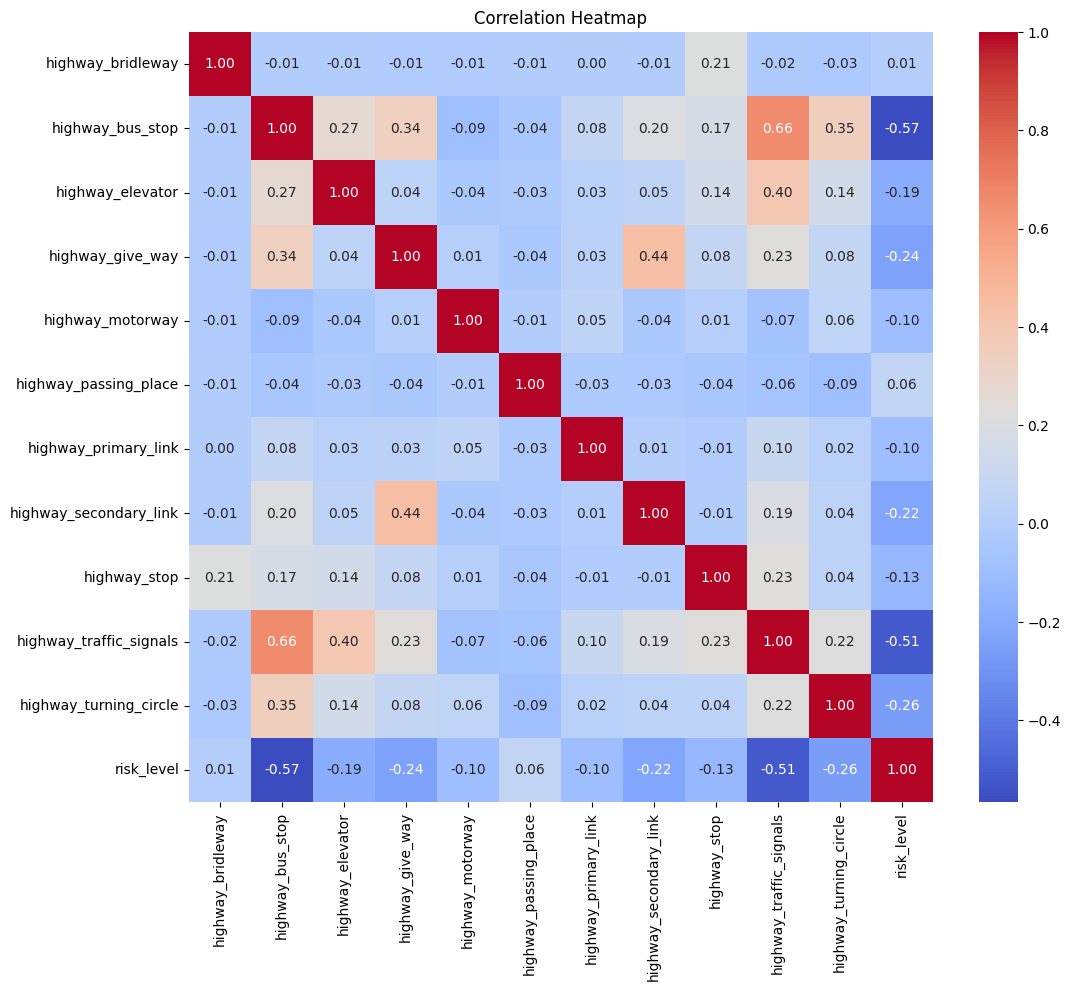

In [5]:
selected_features = ['highway_bridleway',
 'highway_bus_stop',
 'highway_elevator',
 'highway_give_way',
 'highway_motorway',
 'highway_passing_place',
 'highway_primary_link',
 'highway_secondary_link',
 'highway_stop',
 'highway_traffic_signals',
 'highway_turning_circle']

correlation_matrix = gdf_base[selected_features + ['risk_level']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [6]:

correlation_matrix_all = gdf_base[features_list_all_highway + ['risk_level']].corr()

correlation_matrix_all[
    (correlation_matrix_all['risk_level'] > 0.4) | (correlation_matrix_all['risk_level'] < -0.5)
]

,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_elevator,highway_footway,highway_give_way,highway_living_street,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level
highway_bus_stop,-0.009875,1.000000,0.131693,0.384948,0.788448,0.622152,0.266582,0.743731,0.344273,0.353306,...,0.342676,-0.264303,0.022190,0.659035,-0.044611,-0.035111,0.350193,0.068152,0.402350,-0.566947
highway_crossing,-0.028965,0.788448,0.177608,0.381209,1.000000,0.829273,0.302434,0.891425,0.334486,0.373403,...,0.431953,-0.309598,-0.000651,0.874395,-0.026167,-0.017149,0.300608,0.058947,0.450132,-0.612007
highway_cycleway,-0.024946,0.622152,0.142077,0.251564,0.829273,1.000000,0.268394,0.677245,0.212511,0.278528,...,0.386462,-0.189798,-0.021052,0.731276,-0.021342,-0.010036,0.209646,0.063838,0.319766,-0.548603
highway_footway,-0.017571,0.743731,0.119375,0.332571,0.891425,0.677245,0.381126,1.000000,0.277098,0.496699,...,0.367606,-0.296480,-0.007562,0.804981,-0.056276,-0.041611,0.320718,0.072163,0.421311,-0.567542
highway_path,-0.005644,0.680313,0.113411,0.266213,0.744679,0.593897,0.245219,0.798779,0.277955,0.437981,...,0.377012,-0.162274,0.015165,0.683359,-0.052001,-0.042785,0.350505,0.075277,0.332338,-0.551114
highway_service,-0.011806,0.743718,0.125372,0.317934,0.858351,0.654518,0.385764,0.884922,0.272281,0.421310,...,0.424790,-0.298250,-0.009616,0.782670,-0.046114,-0.040656,0.279824,0.153347,0.417982,-0.600366
highway_traffic_signals,-0.022532,0.659035,0.162294,0.511612,0.874395,0.731276,0.398335,0.804981,0.234496,0.282889,...,0.509250,-0.278430,0.004524,1.000000,-0.022968,-0.012309,0.217986,0.151461,0.439839,-0.512597
risk_level,0.007560,-0.566947,-0.111475,-0.145703,-0.612007,-0.548603,-0.192619,-0.567542,-0.237501,-0.315346,...,-0.250422,0.120094,0.019377,-0.512597,-0.055028,-0.069434,-0.260438,-0.068937,-0.240012,1.000000


In [7]:
correlation_matrix_all['risk_level'][correlation_matrix_all['risk_level'] > 0.5]

risk_level    1.0
Name: risk_level, dtype: float64

In [8]:
best_features = correlation_matrix_all['risk_level'][correlation_matrix_all['risk_level'] < -0.5].index.to_list()

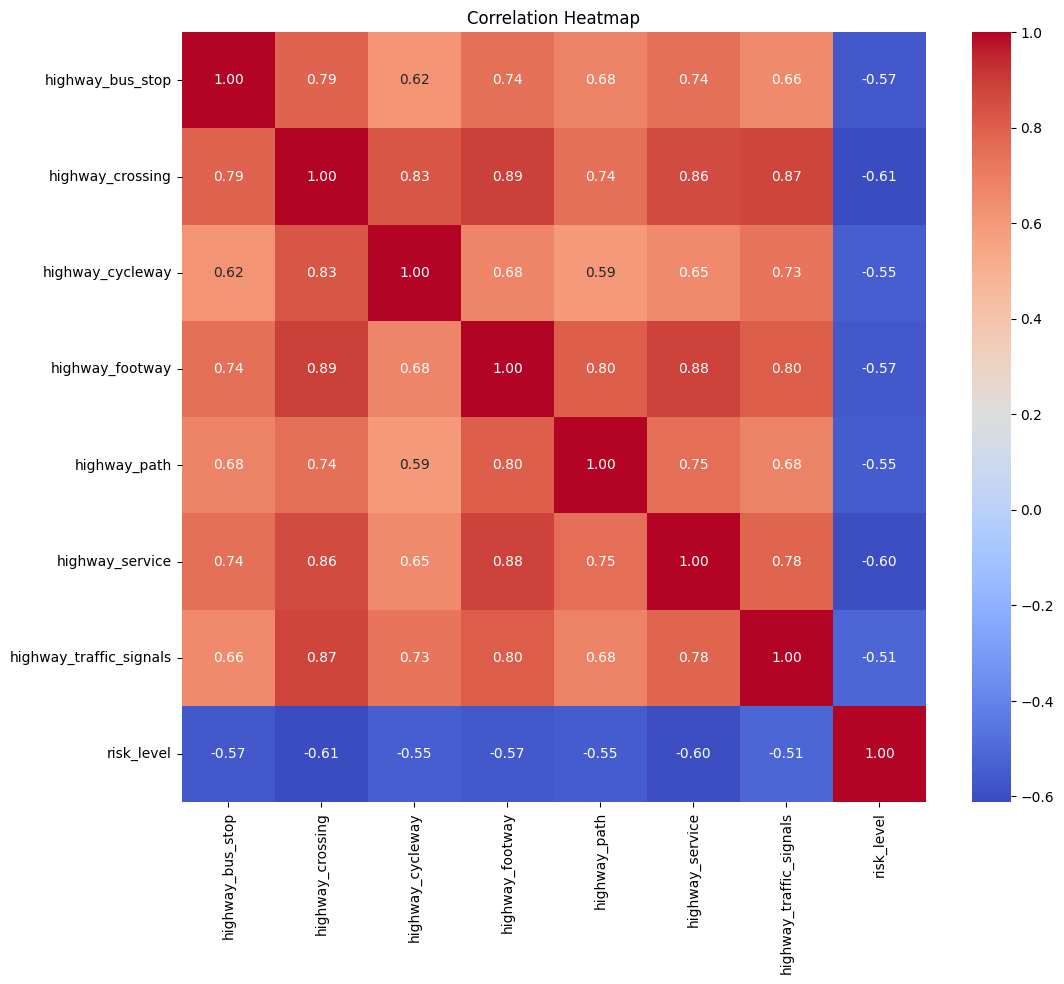

In [9]:
correlation_matrix_best_features = gdf_base[best_features + ['risk_level']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Wyjaśnialność 'risk_level' za pomocą różnych cech:


In [15]:
X = gdf_base[best_features]
X = sm.add_constant(X)

y = gdf_base['risk_level']

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             risk_level   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     45.16
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           2.35e-47
Time:                        23:02:30   Log-Likelihood:                -540.85
No. Observations:                 422   AIC:                             1098.
Df Residuals:                     414   BIC:                             1130.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       2.3429      0.065     36.177      0.000       2.216       2.470
highway_bus_stop           -0.0442      0.019     -2.365      0.018      -0.081      -0.007
highway_crossing           -0.0088      0.006     -1.413      0.159      -0.021       0.003
highway_cycleway           -0.0149      0.005     -2.753      0.006      -0.026      -0.004
highway_footway             0.0008      0.001      1.258      0.209      -0.000       0.002
highway_path               -0.0049      0.002     -2.643      0.009      -0.009      -0.001
highway_service            -0.0047      0.001     -3.373      0.001      -0.007      -0.002
highway_traffic_signals     0.0231      0.014      1.667      0.096      -0.004       0.050
==============================================================================
Omnibus:                      110.875   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.229
Skew:                          -0.437   Prob(JB):                     1.00e-07
Kurtosis:                       1.965   Cond. No.                         364.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

koeficient (coef) - reprezentuje średnią zmianę w zmiennej zależnej na jednostkę zmiany danej cechy, przy założeniu, że pozostałe cechy pozostają stałe

AIC (Akaike Information Criterion) i BIC (Bayesian Information Criterion) - miary oceny modelu, które uwzględniają złożoność modelu, niższe wartości są lepsze

 Jeśli p-value jest mniejsze niż ustalony poziom istotności (zazwyczaj 0.05), możemy uznać koeficient za statystycznie istotny. 

statystycznie istotne są:
- highway_bus_stop
- highway_cycleway
- highway_path
- highway_service
- highway_traffic_signals

___

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import shap


In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(gdf_base['risk_level'])
y_transformed = label_encoder.transform(gdf_base['risk_level'])

X = gdf_base[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)


Using 337 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/85 [00:00<?, ?it/s]

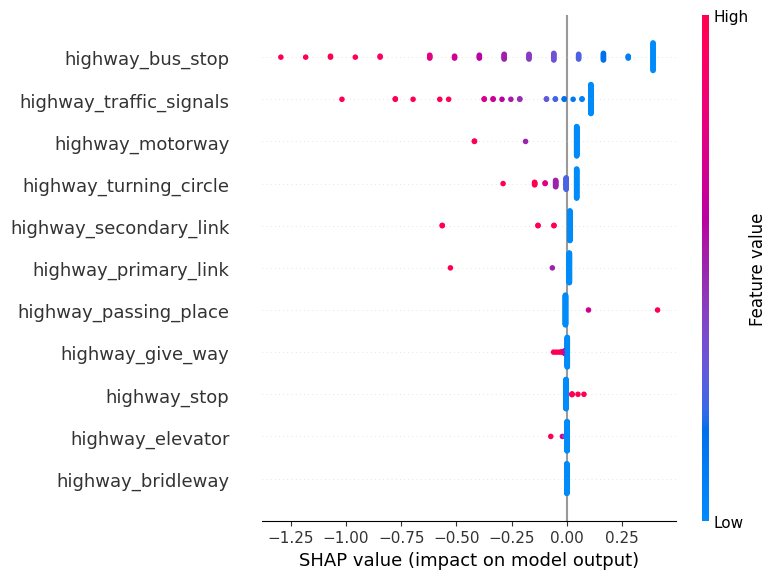

In [30]:
shap.summary_plot(shap_values, X_test)

In [34]:
label_encoder = LabelEncoder()
label_encoder.fit(gdf_base['risk_level'])
y_transformed = label_encoder.transform(gdf_base['risk_level'])

X = gdf_base[features_list_all_highway]

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)



Using 337 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/85 [00:00<?, ?it/s]

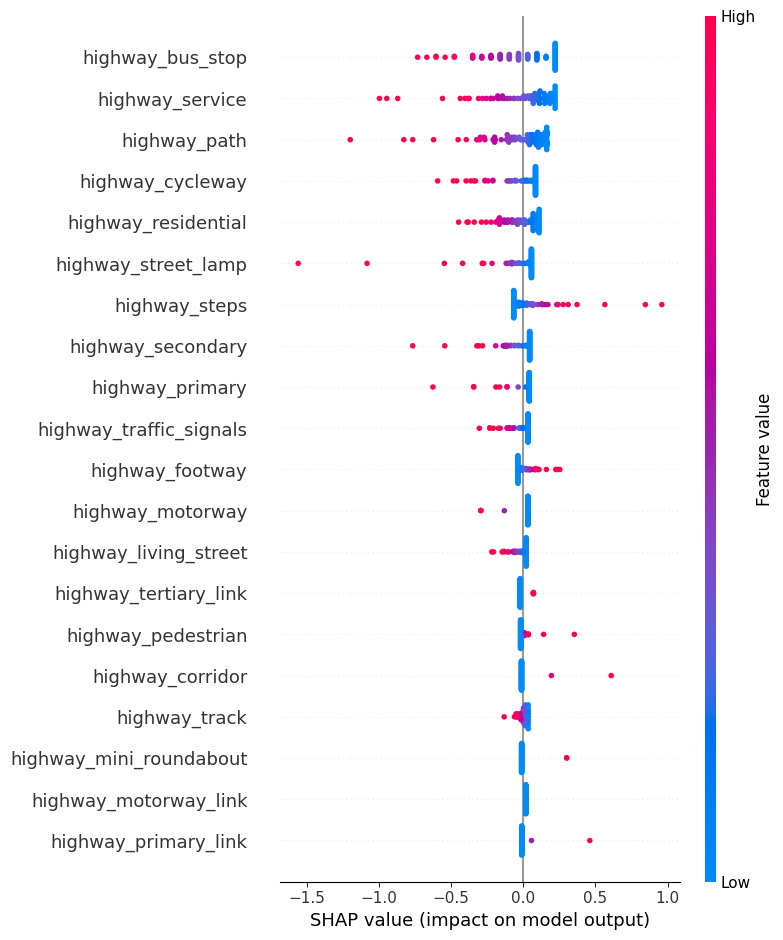

In [36]:
shap.summary_plot(shap_values, X_test)

In [37]:
label_encoder = LabelEncoder()
label_encoder.fit(gdf_base['risk_level'])
y_transformed = label_encoder.transform(gdf_base['risk_level'])

X = gdf_base[best_features]

X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)



Using 337 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/85 [00:00<?, ?it/s]

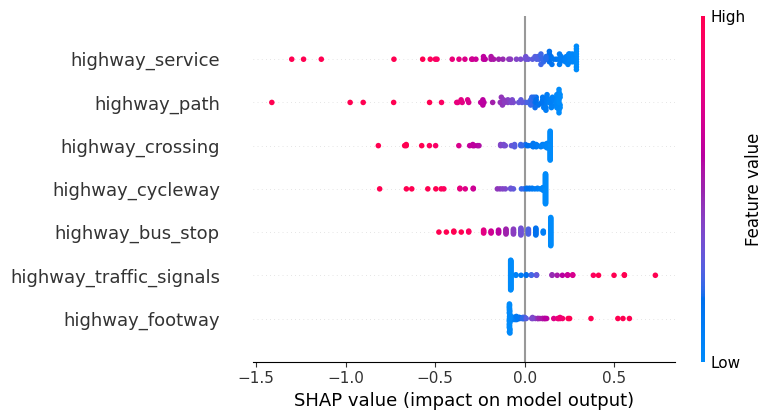

In [38]:
shap.summary_plot(shap_values, X_test)